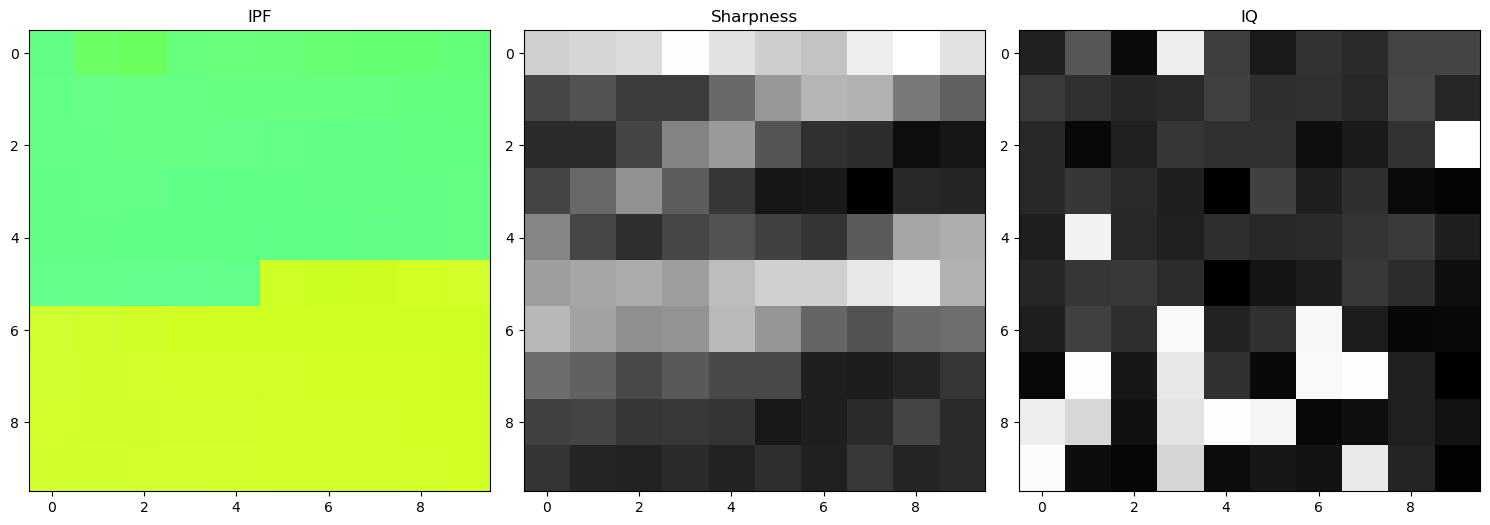

In [3]:
import numpy as np
import imageio.v3 as iio
import os
import HREBSD as hr
import utilities as ut
import matplotlib.pyplot as plt
from matplotlib import patches
from orix.quaternion import Orientation, symmetry
from orix import plot, vector
ipfkey = plot.IPFColorKeyTSL(symmetry.Oh, vector.Vector3d((0, 0, 1)))


# Get orientations
ang_path = "C:/Users/lambj/Downloads/20230707_18187_CoNi_AM_90deg_integrated_frames_integratedframes.ang"
eulerangles = np.genfromtxt(ang_path, comments="#").reshape(640, 640, -1)
eulerangles = eulerangles[321:331, 321:331, :3]
ori = Orientation.from_euler(eulerangles, symmetry=symmetry.Oh)
ipf = ipfkey.orientation2color(ori)

# Get the pattern center
PC = ut.get_PC_from_ang(ang_path)
delta = 6.5
N = (2048, 2048)
PC = ut.convert_pc(PC, N, delta)

# Load the patterns
folder = "D:/Research/CoNi67/Data/HREBSD/"
paths = [f for f in os.listdir(folder) if f.endswith('.tif')]
data = np.zeros((10, 10, 1024, 1024), dtype=np.uint16)
sharpness = np.zeros((10, 10))
iq = np.zeros((10, 10))
for path in paths:
    pat = iio.imread(folder + path)
    pos_info = path.replace(".tif", "").split("_")
    if "x" in pos_info[0]:
        x = int(pos_info[0].replace("x", ""))
        y = int(pos_info[1].replace("y", ""))
    else:
        x = int(pos_info[1].replace("x", ""))
        y = int(pos_info[0].replace("y", ""))
    data[y, x] = pat
    sharpness[y, x] = ut.pattern_sharpness(pat)
    iq[y, x] = pat.sum()

# Plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ipf)
ax[0].set_title("IPF")
ax[1].imshow(sharpness, cmap="binary")
ax[1].set_title("Sharpness")
ax[2].imshow(iq, cmap="gray")
ax[2].set_title("IQ")
plt.tight_layout()
plt.show()

In [10]:
data = data.reshape(-1, 1024, 1024)
pat_ref = data[-1]
test_pats = data
roi_size = 8
n_roi = 21
totaltilt = 70.0
EulerAngle = eulerangles.reshape(-1, 3)[-1]

C11, C12, C44 = 236.4, 150.9, 133.9
C = np.array([[C11, C12, C12, 0, 0, 0],
              [C12, C11, C12, 0, 0, 0],
              [C12, C12, C11, 0, 0, 0],
              [0, 0, 0, C44, 0, 0],
              [0, 0, 0, 0, C44, 0],
              [0, 0, 0, 0, 0, C44]])

strain, rotation, shift_data = hr.HREBSD(pat_ref, test_pats, EulerAngle, n_roi, roi_size, PC, C)

Setup complete
Intensity normalization complete
Interpolation grid and parameters defined
ROI's defined. Performing loop...


  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
print(strain.shape, rotation.shape, shift_data.shape)

(3, 3, 100) (3, 3, 100) (3, 21, 100)


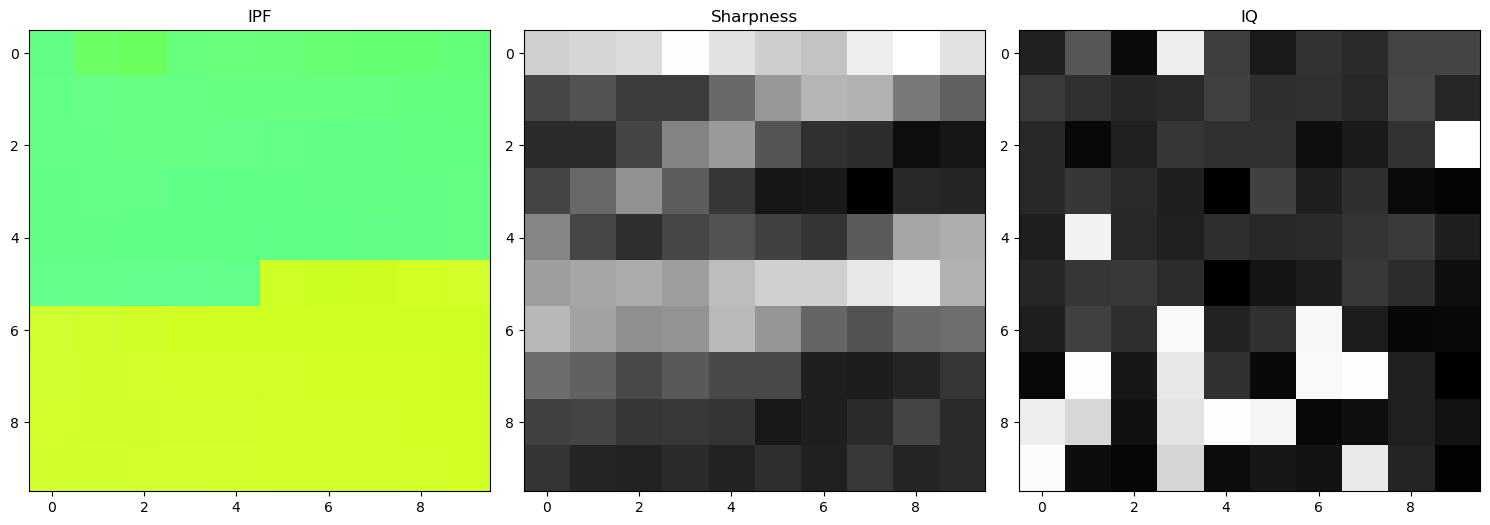

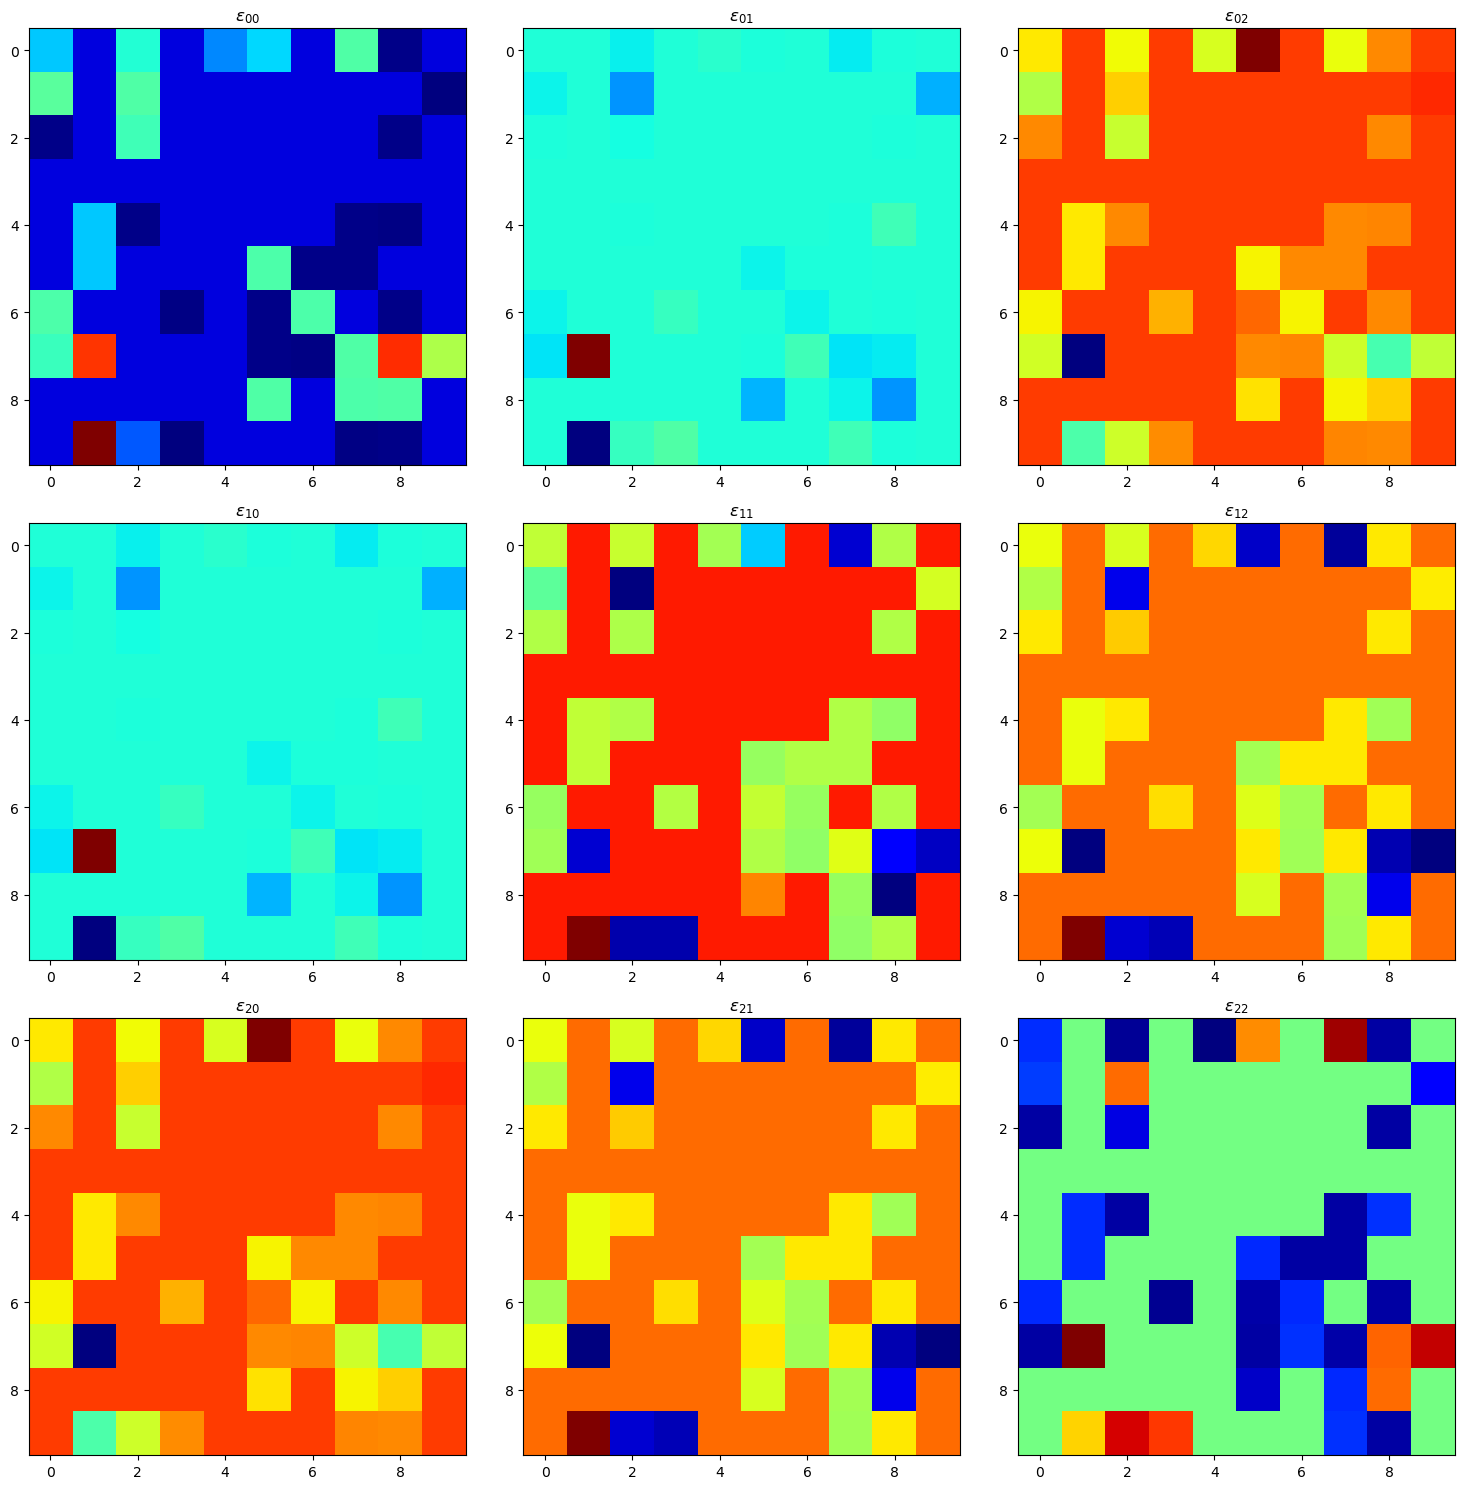

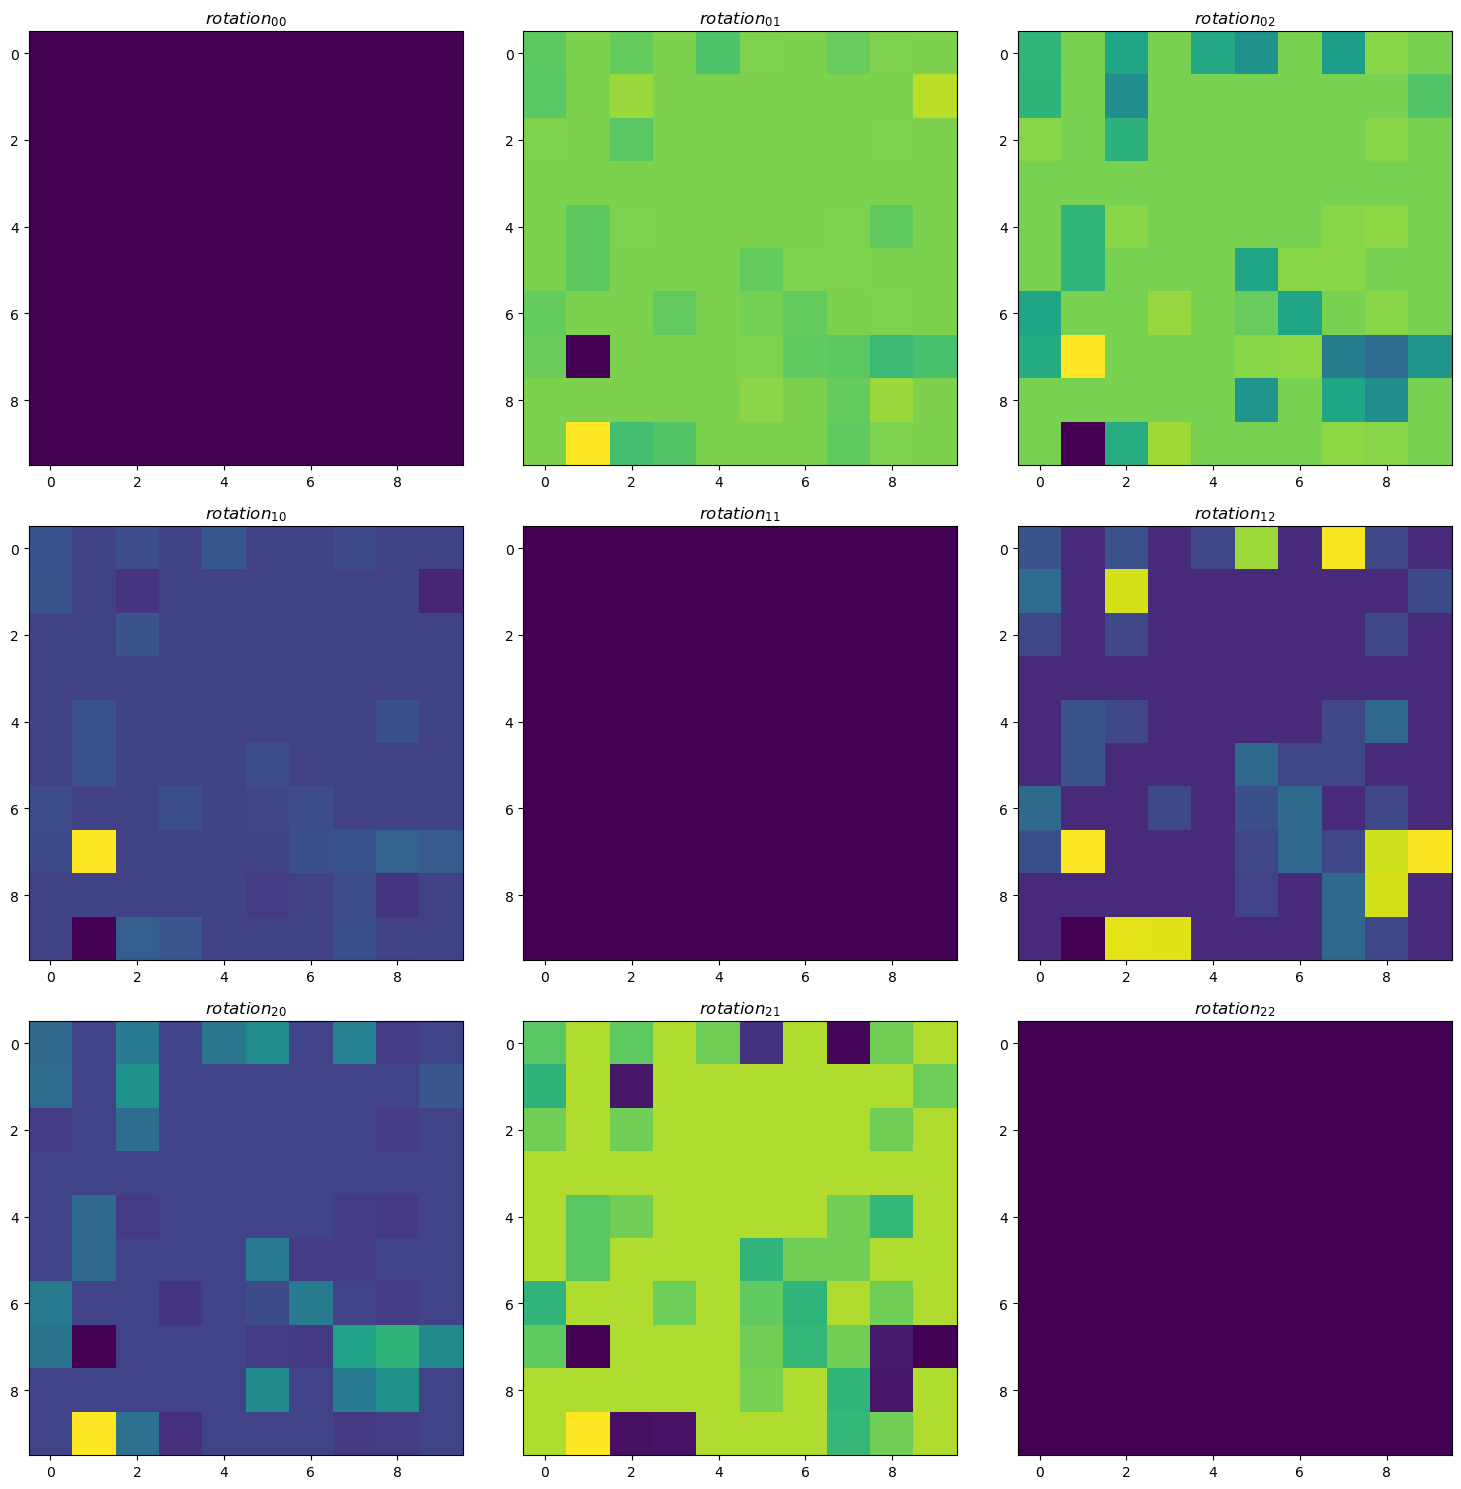

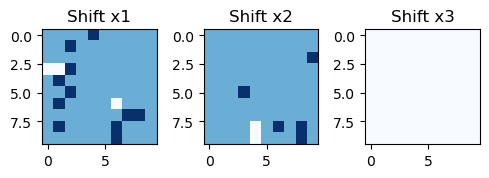

In [13]:
# Plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(ipf)
ax[0].set_title("IPF")
ax[1].imshow(sharpness, cmap="binary")
ax[1].set_title("Sharpness")
ax[2].imshow(iq, cmap="gray")
ax[2].set_title("IQ")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(strain[i, j].reshape(10, 10), cmap="jet")
        ax[i, j].set_title(r"$\epsilon_{" + f"{i}{j}" + r"}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(rotation[i, j].reshape(10, 10), cmap="viridis")
        ax[i, j].set_title(r"$rotation_{" + f"{i}{j}" + r"}$")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(5, 5))
ax[0].imshow(shift_data[0, -1].reshape(10, 10), cmap="Blues")
ax[0].set_title("Shift x1")
ax[1].imshow(shift_data[1, -1].reshape(10, 10), cmap="Blues")
ax[1].set_title("Shift x2")
ax[2].imshow(shift_data[2, -1].reshape(10, 10), cmap="Blues")
ax[2].set_title("Shift x3")
plt.tight_layout()
plt.show()